In [2]:
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [3]:
def preprocess(sentence) :
    stop_words = stopwords.words('english')
    words      = word_tokenize(sentence)
    tokens     = [word.lower() for word in words]
    table      = str.maketrans('', '', string.punctuation)
    stripped   = [w.translate(table) for w in tokens]
    sent       =  ' '.join([word for word in stripped if word.isalnum() and 
                            word not in stop_words])
    return sent

In [4]:
def tfIdf(corpus) :
    corpus    = sent_tokenize(corpus)
    documents = [preprocess(sent) for sent in corpus]
    tfidf     = TfidfVectorizer()
    tfIdf_mat = tfidf.fit_transform(documents)
    df = pd.DataFrame(tfIdf_mat.todense(), columns=tfidf.get_feature_names())
    df['p_sentence'] = [word_tokenize(sent) for sent in documents]
    df['sentences']  = corpus
    return df

In [5]:
from math import sqrt
import numpy as np

In [6]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in range(m + 1)] 
  
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1])  
    return L[m][n] 

In [7]:
def lcs_etoile(s1,s2) :
    if len(s1) == 0:
        return 0
    else :
        l2 = s2.copy()
        s = 0
        for w1 in s1 :
            if len(l2) > 0:
               l = [lcs(w1, w2) for w2 in l2]
               if max(l) > 0 :
                  del l2[l.index(max(l))]
                  if max(l) / len(w1) >= 0.6 :
                    s += max(l) / len(w1)
        return s / float(len(s1))

In [8]:
def cosine(p1,p2) :
    dot_product = sum(p*q for p,q in zip(p1, p2))
    magnitude = sqrt(sum([val**2 for val in p1])) * sqrt(sum([val**2 for val in p2]))
    if not magnitude :
        return 0.0
    return dot_product/magnitude

In [9]:
def similarite(frame, alpha=0.9, similarity_threshold = 0.07) :
        similarities = np.zeros(shape=(frame.values.shape[0],
                                       frame.values.shape[0]))
        degrees = np.zeros(shape=(frame.values.shape[0]))
        for ind1, s1 in frame.iterrows() :
            for ind2, s2 in frame.iterrows() :
                sim = alpha*cosine(s1.values[:len(frame.columns)-2], s2.values[
                      :len(frame.columns)-2]) + (1-alpha)*lcs_etoile(s1.values[
                           -2], s2.values[-2])
                if sim > similarity_threshold :
                   similarities[ind1][ind2] = 1
                   degrees[ind2] += 1
                else :
                    similarities[ind1][ind2] = 0.0
        return  similarities / degrees.reshape(frame.values.shape[0],1), degrees

In [10]:
def powerMethod(similarity_matrix,
                degrees,
                stopping_criterion=0.00005,
                max_loops=3000):
    
    p_initial = np.ones(shape=len(degrees))/len(degrees)
    i = 0
    # loop until no change between successive matrix iterations
    while True:
        i += 1
        p_update = np.matmul(similarity_matrix.T, p_initial)
        delta = np.linalg.norm(p_update - p_initial)
        if delta < stopping_criterion or i >= max_loops:
            break
        else:
            p_initial = p_update
    p_update = p_update/np.max(p_update)
    return p_update


In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
class Summarization :
        
    def __init__(self, corpus, sum_size = 5) :
        self.corpus = corpus
        self.sum_size   = sum_size
        self.scores     = ''
        self.similarite = '' 
        
    def summarize(self) :
        tf_idf = tfIdf(self.corpus)
        self.similarite, degrees = similarite(tf_idf)
        self.scores  = powerMethod(self.similarite, degrees)
        sent_index   = np.argsort(self.scores )[::-1][:self.sum_size]
        sent_index.sort()
        sent_list    = list(tf_idf.loc[sent_index]['sentences'].values)
        summu        = ' '.join(sent_list)
        return summu
        
    
    def graph(self) :
        edges = []
        for ids, v in enumerate(self.similarite) :
            for i, s in enumerate(v) :
                if i != ids and s > 0.0 :
                   edges.append(("s"+str(ids), "s"+str(i)))
        G = nx.Graph()
        G.add_edges_from(edges)
        options = {'node_size':300, 'node_color':'red', 'with_labels':True}
        nx.draw_circular(G, **options)
        plt.show()

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
corpus2 ="""SYDNEY (AP) — Skipper Pat Cummins has left Australia’s cricket tour to India for a brief visit to Sydney because of a serious family illness.
Cricket Australia issued a statement Monday saying Cummins flew home for personal reasons but is scheduled to return to India in time to prepare for the third test of the series at Indore, starting March 1.
Australia is already 2-0 down in the four-match series after two heavy defeats, allowing India to retain the Border-Gavaskar Trophy.
The Australian team came under heavy criticism for a batting collapse on Sunday that saw them slump from a competitive position to a six-wicket loss in the space of one session.
The 29-year-old Cummins was the only paceman in a bowling attack that featured three specialist spinners in the second test in New Delhi, a rarity for Australia’s test lineup.
"""

In [14]:
corpus1 ="""Amitabh Bachchan (pronounced [əmɪˈt̪ɑːbʱ ˈbətːʃən]; born as Amitabh Shrivastav;[1] 11 October 1942[7]) is an Indian actor, film producer, television host, occasional playback singer and former politician known for his work in Hindi cinema. He is regarded as one of the most successful and influential actors in the history of Indian cinema.[8] Referred to as the Shahenshah of Bollywood (in reference to his 1988 film Shahenshah), Sadi ka Mahanayak (Hindi for, "Greatest actor of the century"), Star of the Millennium, or Big B.[9] His dominance in the Indian movie scene during the 1970s–1980s made the French director François Truffaut call it a "one-man industry".[10]
Bachchan was born in 1942 in Allahabad to the Hindi poet Harivansh Rai Bachchan and his wife, the social activist Teji Bachchan. He was educated at Sherwood College, Nainital, and Kirori Mal College, University of Delhi. His film career started in 1969 as a voice narrator in Mrinal Sen's film Bhuvan Shome. He first gained popularity in the early 1970s for films such as Zanjeer, Deewaar and Sholay, and achieved greater stardom in later years, dubbed India's "angry young man" for some several of his on-screen roles in Hindi films. He has since appeared in over 200 Indian films in a career spanning more than five decades,[11] He has won numerous accolades in his career, including four National Film Awards as Best Actor, Dadasaheb Phalke Award as lifetime achievement award and many awards at international film festivals and award ceremonies. He has won sixteen Filmfare Awards and is the most nominated performer in any major acting category at Filmfare, with 42 nominations overall. In addition to acting, Bachchan has worked as a playback singer, film producer and television presenter. He has hosted several seasons of the game show Kaun Banega Crorepati, India's version of the game show franchise, Who Wants to Be a Millionaire?. He also entered politics for a time in the 1980s.
The Government of India honoured him with the Padma Shri in 1984, the Padma Bhushan in 2001 and the Padma Vibhushan in 2015 for his contributions to the arts. The Government of France honoured him with its highest civilian honour, Knight of the Legion of honour, in 2007 for his exceptional career in the world of cinema and beyond. Bachchan also made an appearance in a Hollywood film, Baz Luhrmann's The Great Gatsby (2013), in which he played a non-Indian Jewish character, Meyer Wolfsheim.
Beyond the Indian subcontinent, he acquired a large overseas following of the South Asian diaspora, as well as others, in markets including Africa (South Africa, Eastern Africa and Mauritius), the Middle East (especially UAE and Egypt), the United Kingdom, Russia, Central Asia, the Caribbean (Guyana, Suriname, and Trinidad and Tobago), Oceania (Fiji, Australia, and New Zealand), Canada and the United States
"""

In [16]:
doc  = Summarization(corpus2,1) 
my_sum = doc.summarize() 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


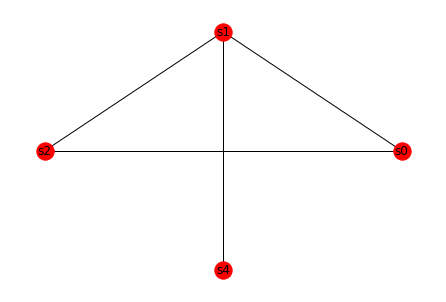

In [17]:
doc.graph()

In [18]:
my_sum

'Cricket Australia issued a statement Monday saying Cummins flew home for personal reasons but is scheduled to return to India in time to prepare for the third test of the series at Indore, starting March 1.'

In [20]:
doc2 = Summarization(corpus1,1) 
my_sum = doc2.summarize() 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


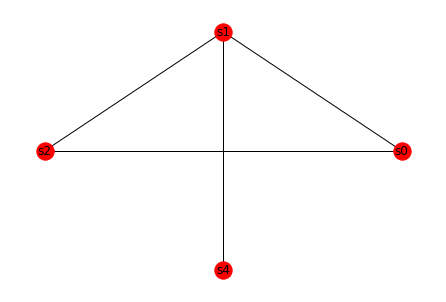

In [21]:
doc.graph()

In [22]:
my_sum

'Amitabh Bachchan (pronounced [əmɪˈt̪ɑːbʱ ˈbətːʃən]; born as Amitabh Shrivastav;[1] 11 October 1942[7]) is an Indian actor, film producer, television host, occasional playback singer and former politician known for his work in Hindi cinema.'